# Evaluacion de los modelos

## lectura de los csv por numero de intento

In [133]:
#%%
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_slice, plot_contour
from time import time
import pickle
import os
from dotenv import load_dotenv
import urllib
import gcsfs
import os
import re


In [2]:
# !gsutil -m cp -r gs://jgjuarac/exp/csv/sinsampling_basico .tmp/sinsampling_basico

In [3]:
# !gsutil -m cp -r gs://jgjuarac/exp/modelos/sinsampling_basico .tmp/sinsampling_basico

In [134]:
st = "mysql+mysqldb://{u}:{p}@{ip}:3306/optuna_rf_db".format(p=urllib.parse.quote_plus(os.getenv("password")), u = os.getenv("usersrv"), ip = os.getenv("ip"))


In [141]:
optuna.get_all_study_names(st)

['exp_206_random-forest-opt',
 'exp_206_random-forest-opt-20240905',
 'rf-segmentacion',
 'rf-segmentacion-0',
 'rf-segmentacion-1',
 'rf-segmentacion-2',
 'rf-segmentacion-3',
 'rf-segmentacion-4',
 'rf-segmentacion-5',
 'rf-segmentacion-6',
 'rf-segmentacion-7',
 'rf-segmentacion-8',
 'rf-segmentacion-9',
 'rf-segmentacion-solobajas',
 'rf-segmentacion-0-solobajas',
 'rf-segmentacion-1-solobajas',
 'lgbm_binaria_t1',
 'lgbm_binaria_t2',
 'lgbm_binaria_t3',
 'lgbm_binaria_t4',
 'lgbm_binaria_t5',
 'experimento_linea_base',
 'experimento_sampling_20perc',
 'sinsampling_basico',
 'sampling20_basico',
 'sinsampling_basico_min_gain7000',
 'sinsampling_basico_min_gain7000_minleaf_500']

In [142]:


study = optuna.load_study(
    study_name= "sinsampling_basico_min_gain7000",
    storage= st)



In [143]:
st_df = study.trials_dataframe().sort_values("value", ascending = False)

In [144]:
top_trials = [study.trials[i] for i in st_df.head(3).number.values]
top_trials

[FrozenTrial(number=17, state=1, values=[62095833.333333336], datetime_start=datetime.datetime(2024, 11, 3, 17, 30, 37), datetime_complete=datetime.datetime(2024, 11, 3, 17, 31, 45), params={'p_min_data_in_leaf': 0.027086862224053942, 'num_leaves': 8581, 'learning_rate': 0.056075124091565835, 'feature_fraction': 0.22464195593210762, 'feature_fraction_bynode': 0.3881669174838641, 'drop_rate': 0.18269989994335695}, user_attrs={'best_iter': 4, 'sampling': 208962, 'seed': 208962, 'train_months': [202011, 202012, 202101, 202102, 202103, 202104]}, system_attrs={}, intermediate_values={}, distributions={'p_min_data_in_leaf': FloatDistribution(high=0.05, log=False, low=0.001, step=None), 'num_leaves': IntDistribution(high=10000, log=False, low=20, step=1), 'learning_rate': FloatDistribution(high=0.4, log=False, low=0.001, step=None), 'feature_fraction': FloatDistribution(high=0.9, log=False, low=0.005, step=None), 'feature_fraction_bynode': FloatDistribution(high=0.9, log=False, low=0.05, step

In [146]:
# get best iteration for top trials
best_iterations = []
for trial in top_trials:
    best_iterations.append(trial.params["n_estimators"])

best_iterations

KeyError: 'n_estimators'

In [139]:
[trial.params for trial in top_trials]

[{'p_min_data_in_leaf': 0.027086862224053942,
  'num_leaves': 8581,
  'learning_rate': 0.056075124091565835,
  'feature_fraction': 0.22464195593210762,
  'feature_fraction_bynode': 0.3881669174838641,
  'drop_rate': 0.18269989994335695},
 {'p_min_data_in_leaf': 0.02962675684506563,
  'num_leaves': 8255,
  'learning_rate': 0.026441078915917973,
  'feature_fraction': 0.4470893675378965,
  'feature_fraction_bynode': 0.46350863603160425,
  'drop_rate': 0.17115711501075592},
 {'p_min_data_in_leaf': 0.0325807626759983,
  'num_leaves': 9567,
  'learning_rate': 0.045450418895774725,
  'feature_fraction': 0.3184311216882857,
  'feature_fraction_bynode': 0.34790883636210523,
  'drop_rate': 0.14397513294915787}]

In [140]:

def read_files_as_dataframes(directory_path, file_extension='.csv'):
    dataframes = []
    
    # Iterate over all files in the directory
    for filename in os.listdir(directory_path):
      if 'df_cut_point' in filename:
            file_path = os.path.join(directory_path, filename)
            # Read the file as a Pandas DataFrame
            print(f'Reading file {file_path}')
            df = pd.read_csv(file_path)
            df['model'] = filename.split('-')[1]
            df['trial'] = filename.split('-')[2]
            df['semilla'] = filename.split('-')[3]
            df.rename(columns={'public_cum':'public_score_acumulado',
                               'private_cum':'private_score_acumulado'}, inplace=True)
            dataframes.append(df)
    
    return dataframes



In [116]:
directory_path = '.tmp/sinsampling_basico/'

dataframes = read_files_as_dataframes(directory_path)




Reading file .tmp/sinsampling_basico_all_features/df_cut_point-sinsampling_basico-113-208961-mayo.csv
Reading file .tmp/sinsampling_basico_all_features/df_cut_point-sinsampling_basico-113-208962-mayo.csv
Reading file .tmp/sinsampling_basico_all_features/df_cut_point-sinsampling_basico-113-549937-mayo.csv
Reading file .tmp/sinsampling_basico_all_features/df_cut_point-sinsampling_basico-113-549938-mayo.csv
Reading file .tmp/sinsampling_basico_all_features/df_cut_point-sinsampling_basico-113-780587-mayo.csv
Reading file .tmp/sinsampling_basico_all_features/df_cut_point-sinsampling_basico-113-780588-mayo.csv
Reading file .tmp/sinsampling_basico_all_features/df_cut_point-sinsampling_basico-113-792991-mayo.csv
Reading file .tmp/sinsampling_basico_all_features/df_cut_point-sinsampling_basico-113-792992-mayo.csv
Reading file .tmp/sinsampling_basico_all_features/df_cut_point-sinsampling_basico-113-886969-mayo.csv
Reading file .tmp/sinsampling_basico_all_features/df_cut_point-sinsampling_basico-

In [99]:
def plot_scores(dataframe, trial):
    plt.figure(figsize=(10, 6))
    for i in dataframe['semilla'].unique():
        df_semilla = dataframe[dataframe['semilla'] == i]
        plt.plot(df_semilla['nro_envios'], df_semilla['public_score_acumulado'], label=f'Public {i}')
        plt.plot(df_semilla['nro_envios'], df_semilla['private_score_acumulado'], label=f'Private {i}')
    
    plt.title(f'Public and Private Scores {trial}')
    plt.xlabel('Envios')
    plt.ylabel('Scores')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [117]:
# bind all dataframes together
dataframes_concat = pd.concat(dataframes)
dataframes_concat['trial'].unique()

array(['113', '158', '178'], dtype=object)

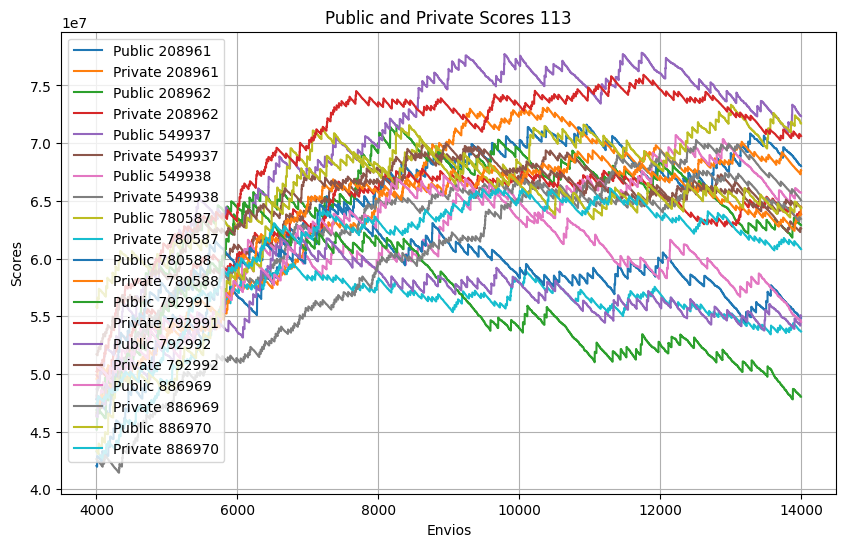

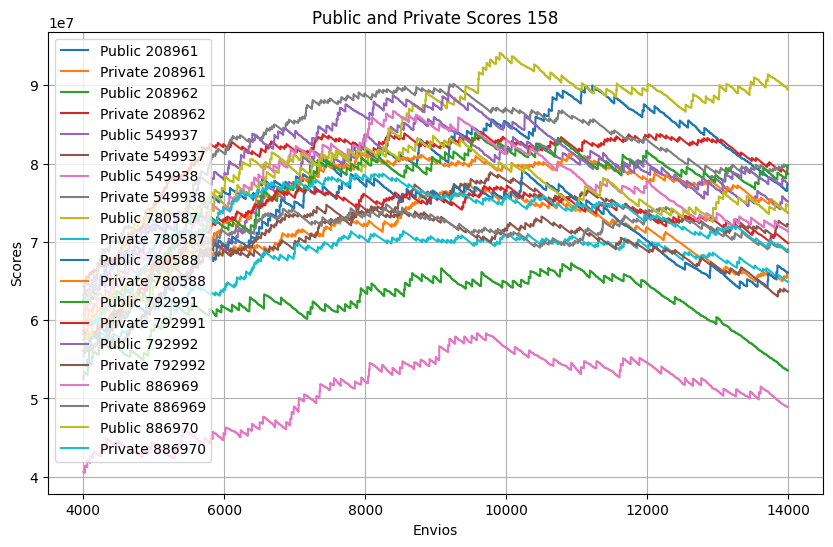

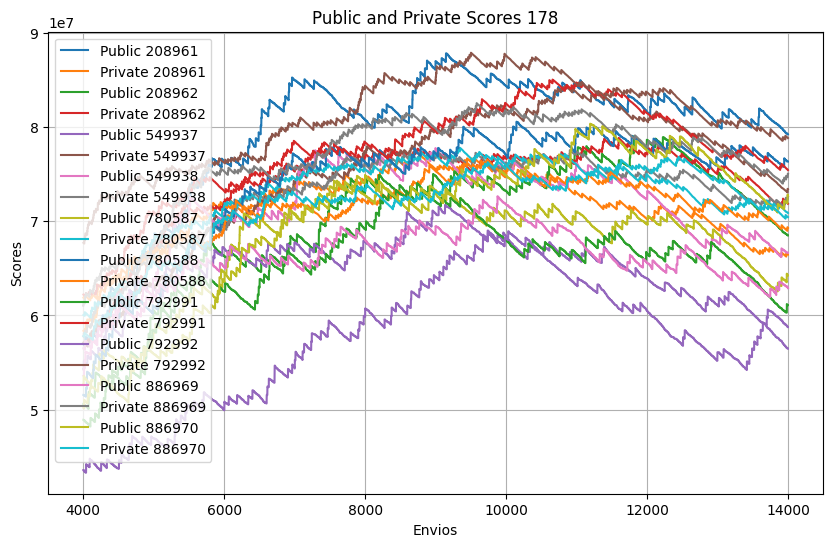

In [10]:
for i in dataframes_concat['trial'].unique():
    df = dataframes_concat[(dataframes_concat['trial'] == i) & (dataframes_concat['nro_envios'] > 4000) & (dataframes_concat['nro_envios'] < 14000)]
    plot_scores(df, i)

In [101]:
def plot_scores_mean(dataframe, trial):
    plt.figure(figsize=(10, 6))
    
    # Calculate the mean and standard deviation for public and private scores
    public_mean = dataframe['public_score_acumulado']
    public_std = dataframe['public_score_acumulado'].std()
    private_mean = dataframe['private_score_acumulado']
    private_std = dataframe['private_score_acumulado'].std()
    
    # Plot the mean scores
    plt.plot(dataframe['nro_envios'], public_mean, label=f'Public {trial}')
    plt.plot(dataframe['nro_envios'], private_mean, label=f'Private {trial}')
    
    # Add confidence intervals
    plt.fill_between(dataframe['nro_envios'], public_mean - public_std, public_mean + public_std, alpha=0.2)
    plt.fill_between(dataframe['nro_envios'], private_mean - private_std, private_mean + private_std, alpha=0.2)
    
    plt.title(f'Public and Private Scores {trial}')
    plt.xlabel('Envios')
    plt.ylabel('Scores')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

In [130]:
from scipy.stats import wilcoxon

for trial in dataframes_concat['trial'].unique():

    print(f'Trial {trial}')

    # Extract private scores from dataframes and dataframes_b
    private_scores = dataframes_concat.loc[dataframes_concat['trial'] == trial,'private']
    private_scores_b = dataframes_concat_b.loc[dataframes_concat_b['trial'] == trial,'private']


    # Perform the Wilcoxon signed-rank test
    stat, p_value = wilcoxon(private_scores, private_scores_b)

    print(f'Wilcoxon test statistic: {stat}')
    print(f'p-value: {p_value}')



Trial 113
Wilcoxon test statistic: 107630360.5
p-value: 0.7322026565593514
Trial 158
Wilcoxon test statistic: 106809814.5
p-value: 0.92310133002084
Trial 178
Wilcoxon test statistic: 106523497.0
p-value: 0.8961107801153159


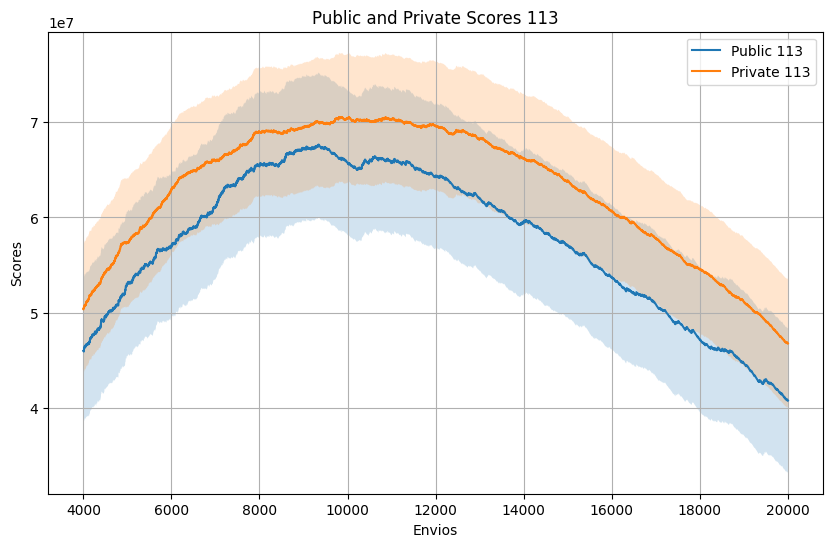

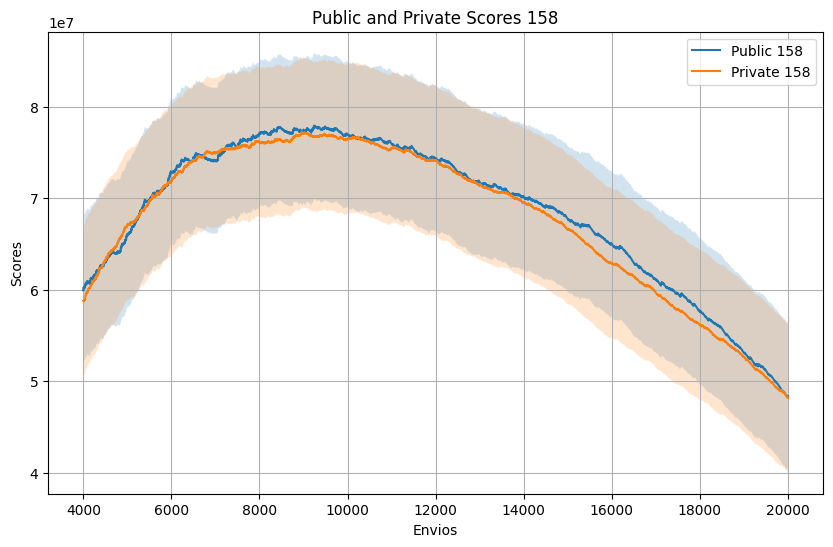

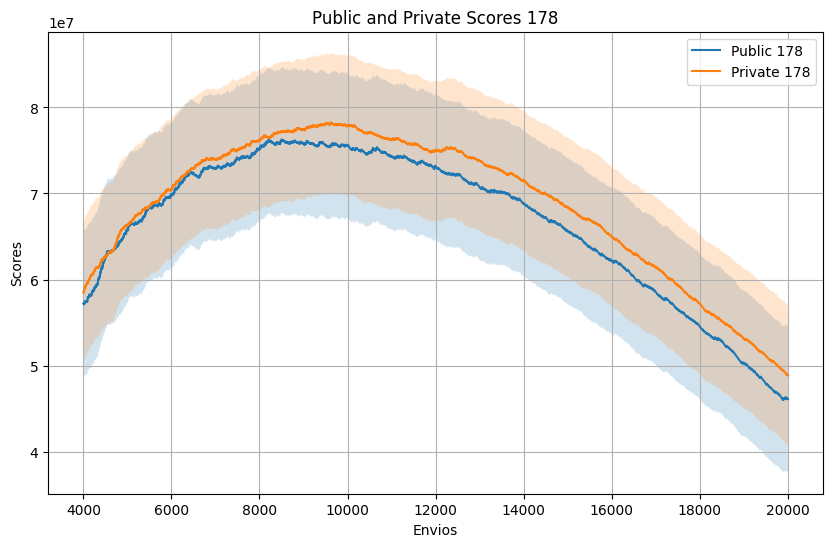

In [102]:
for i in dataframes_concat['trial'].unique():
    df = dataframes_concat[(dataframes_concat['trial'] == i) & (dataframes_concat['nro_envios'] > 4000) & (dataframes_concat['nro_envios'] < 20000)]
    # calculate the mean of public and private scores, excluding non-numeric columns
    df_mean = df.groupby('nro_envios').mean(numeric_only=True).reset_index()
    plot_scores_mean(df_mean, i)

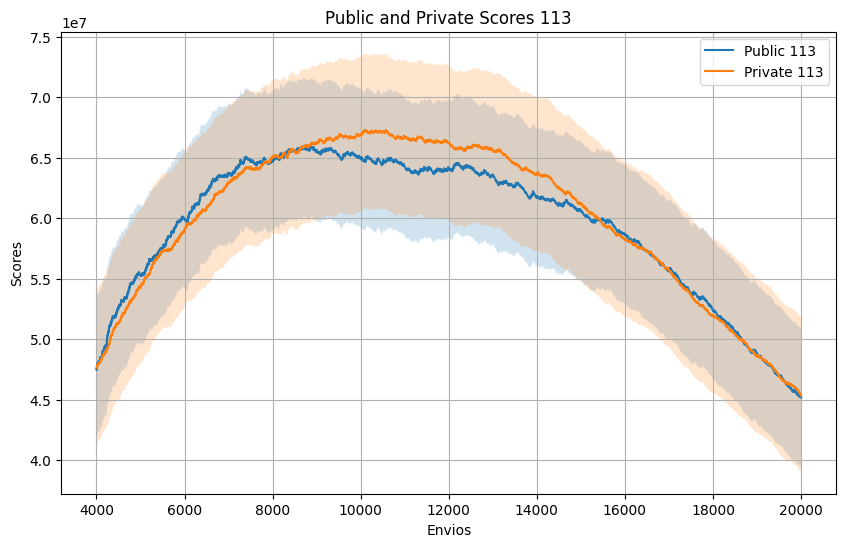

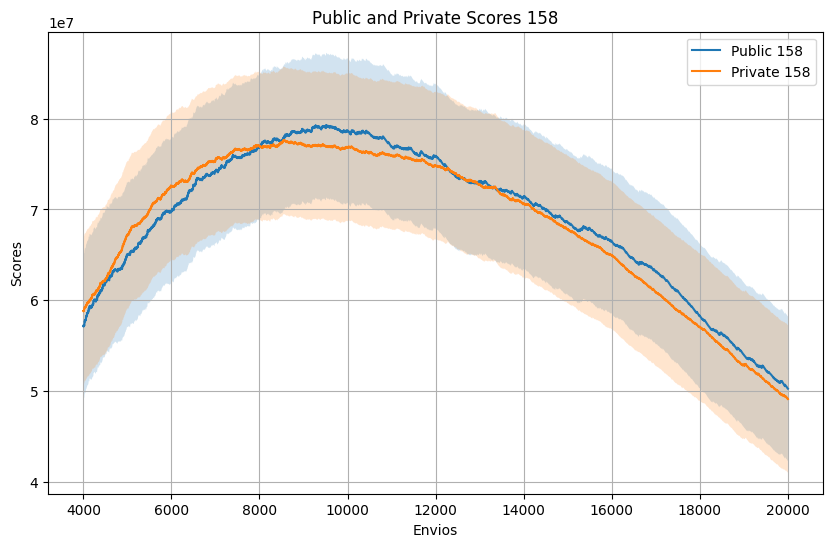

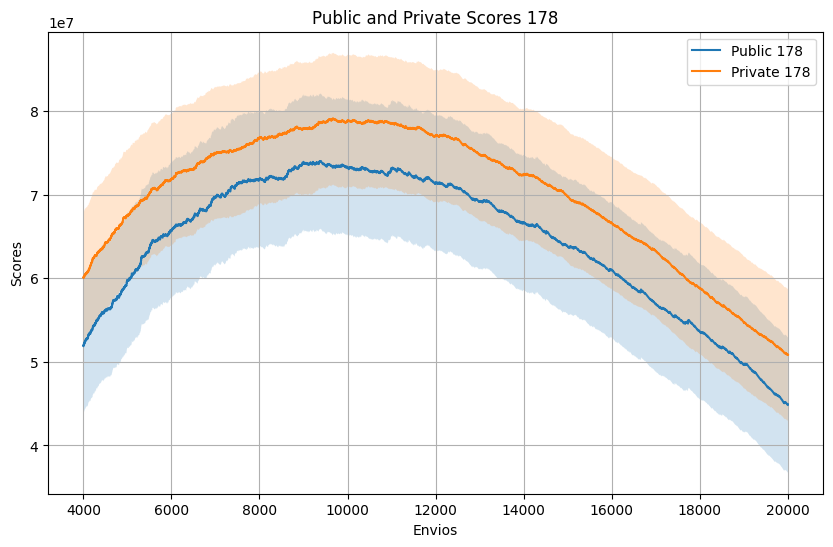

In [12]:
for i in dataframes_concat['trial'].unique():
    df = dataframes_concat[(dataframes_concat['trial'] == i) & (dataframes_concat['nro_envios'] > 4000) & (dataframes_concat['nro_envios'] < 20000)]
    # calculate the mean of public and private scores, excluding non-numeric columns
    df_mean = df.groupby('nro_envios').mean(numeric_only=True).reset_index()
    plot_scores_mean(df_mean, i)

In [103]:
# read all models from trial 158
model = 158
models = []

# list files in the directory
model_files = os.listdir(f'.tmp/sinsampling_basico/')
model_files = [x for x in model_files if x.endswith('.pkl')]

In [104]:
# get features importance for each model
for model_file in [x for x in model_files if f'-{model}-' in x]:
    with open(f'.tmp/sinsampling_basico/{model_file}', 'rb') as f:
        model = pickle.load(f)
        models.append(model)
        

In [106]:
# create a DataFrame with the feature importances
feature_importances = pd.DataFrame()
for i, model in enumerate(models):
    print(f'Getting feature importances for model {i}')
    feature_importances[f'fimportance_model'] = model.feature_importance()
    feature_importances[f'fname_model'] = model.feature_name()
    feature_importances[f'model'] = i



Getting feature importances for model 0
Getting feature importances for model 1
Getting feature importances for model 2
Getting feature importances for model 3
Getting feature importances for model 4
Getting feature importances for model 5
Getting feature importances for model 6
Getting feature importances for model 7
Getting feature importances for model 8
Getting feature importances for model 9


In [107]:
feature_importances.describe()

,fimportance_model,model
count,596.000000,596.0
mean,489.152685,9.0
std,633.852048,0.0
min,0.000000,9.0
25%,55.750000,9.0
50%,232.500000,9.0
75%,615.500000,9.0
max,3440.000000,9.0


In [108]:
resumen_feature_importances = feature_importances.groupby('fname_model').mean().sort_values('fimportance_model', ascending=False)
resumen_feature_importances

,fimportance_model,model
fname_model,,
lag1_mrentabilidad_annual,3440.0,9.0
lag2_mrentabilidad_annual,3163.0,9.0
mactivos_margen,2977.0,9.0
lag2_cliente_edad,2931.0,9.0
lag1_cliente_edad,2927.0,9.0
...,...,...
ccuenta_corriente,0.0,9.0
lag2_Visa_madelantodolares,0.0,9.0
mtc_adelantodolares_total,0.0,9.0


In [109]:
resumen_feature_importances['log_fimportance_model'] = np.log1p(resumen_feature_importances['fimportance_model'])

<Axes: ylabel='fname_model'>

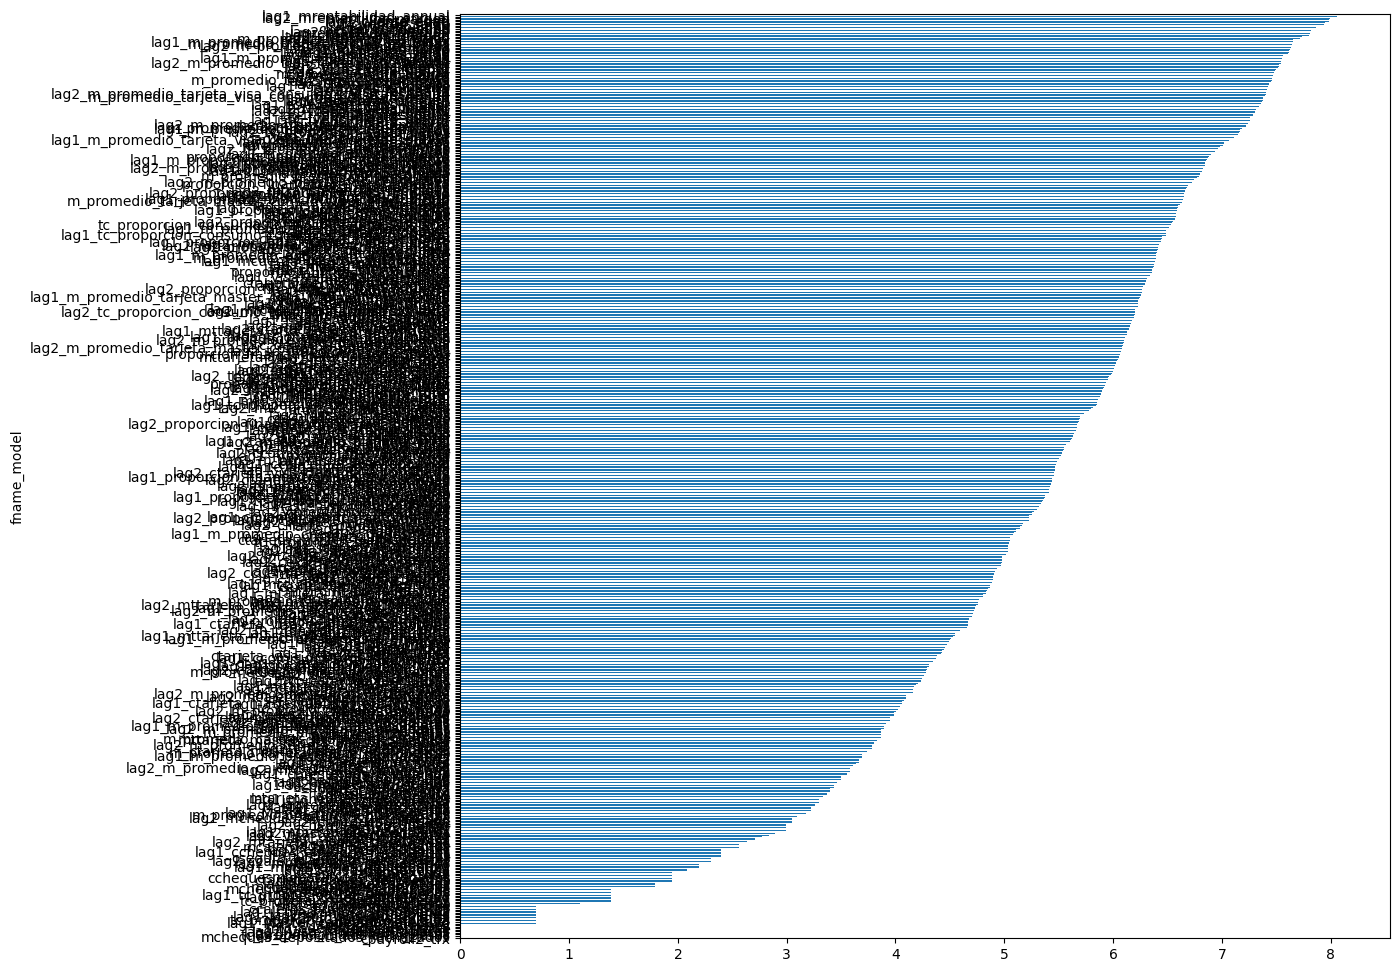

In [110]:
resumen_feature_importances.loc[:,'log_fimportance_model'].sort_values(ascending=True).plot(kind='barh', figsize=(12, 12))

<Axes: ylabel='fname_model'>

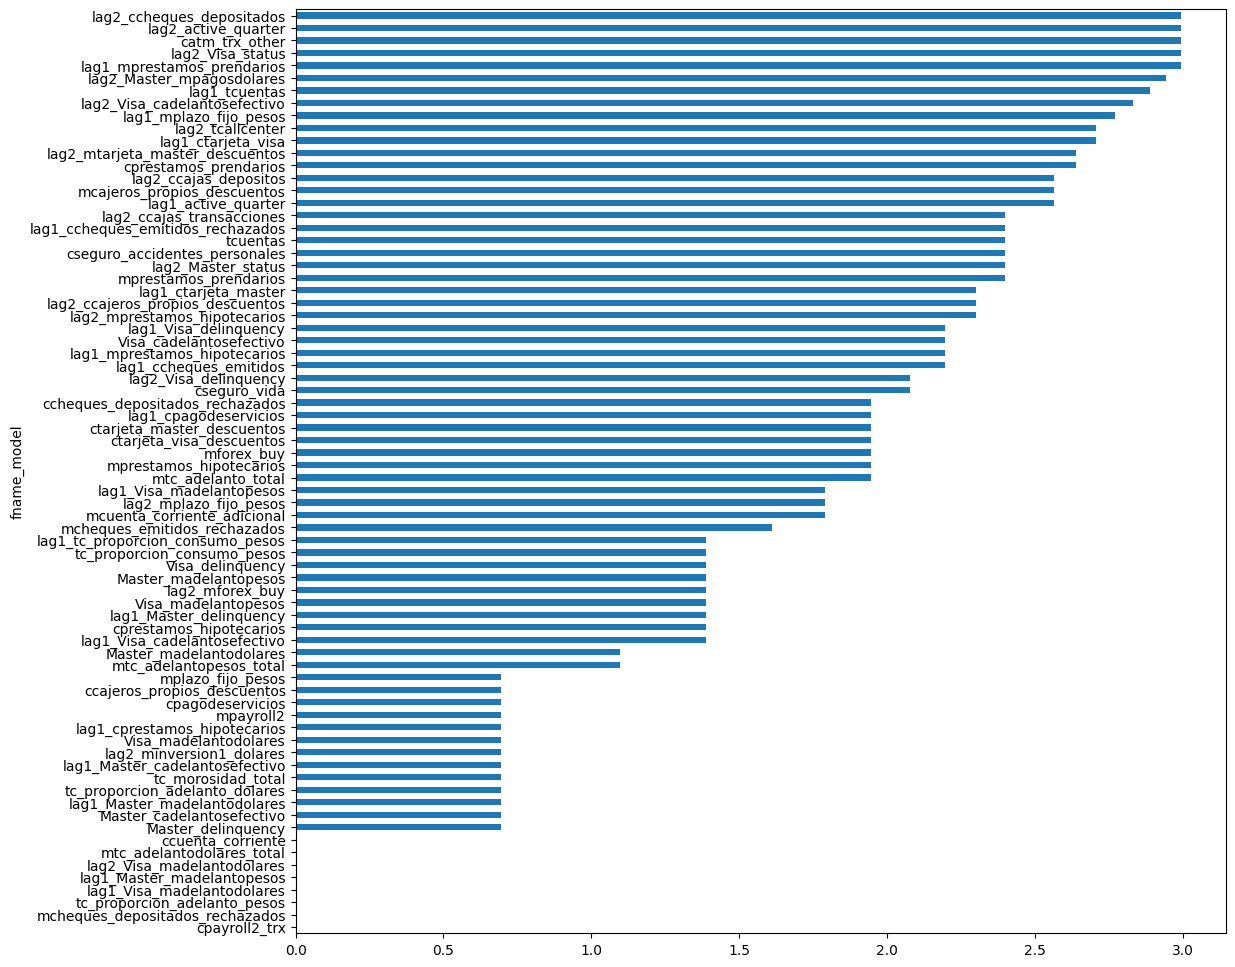

In [111]:
resumen_feature_importances.loc[resumen_feature_importances.log_fimportance_model < 3, 'log_fimportance_model'].sort_values(ascending=True).plot(kind='barh', figsize=(12, 12))

In [112]:
resumen_feature_importances.loc[resumen_feature_importances.log_fimportance_model < 3, 'log_fimportance_model'].count()

74

In [36]:
364/30

12.133333333333333

In [113]:
resumen_feature_importances.loc[resumen_feature_importances.log_fimportance_model < 3, 'log_fimportance_model'].index.tolist()

['lag2_ccheques_depositados',
 'lag2_active_quarter',
 'catm_trx_other',
 'lag2_Visa_status',
 'lag1_mprestamos_prendarios',
 'lag2_Master_mpagosdolares',
 'lag1_tcuentas',
 'lag2_Visa_cadelantosefectivo',
 'lag1_mplazo_fijo_pesos',
 'lag2_tcallcenter',
 'lag1_ctarjeta_visa',
 'lag2_mtarjeta_master_descuentos',
 'cprestamos_prendarios',
 'lag2_ccajas_depositos',
 'mcajeros_propios_descuentos',
 'lag1_active_quarter',
 'mprestamos_prendarios',
 'cseguro_accidentes_personales',
 'lag2_Master_status',
 'lag2_ccajas_transacciones',
 'tcuentas',
 'lag1_ccheques_emitidos_rechazados',
 'lag1_ctarjeta_master',
 'lag2_ccajeros_propios_descuentos',
 'lag2_mprestamos_hipotecarios',
 'lag1_Visa_delinquency',
 'Visa_cadelantosefectivo',
 'lag1_mprestamos_hipotecarios',
 'lag1_ccheques_emitidos',
 'lag2_Visa_delinquency',
 'cseguro_vida',
 'lag1_cpagodeservicios',
 'ctarjeta_master_descuentos',
 'ctarjeta_visa_descuentos',
 'mforex_buy',
 'ccheques_depositados_rechazados',
 'mprestamos_hipotecarios'

In [38]:
resumen_feature_importances['root_name'] = resumen_feature_importances.index.to_series().apply(lambda x: re.sub(r'^(lag1_|lag2_)', '', x))


,fimportance_model,model,log_fimportance_model,root_name
fname_model,,,,
lag1_mrentabilidad_annual,558.0,39.0,6.326149,mrentabilidad_annual
lag2_mrentabilidad_annual,517.0,39.0,6.249975,mrentabilidad_annual
lag2_mactivos_margen,410.0,39.0,6.018593,mactivos_margen
mrentabilidad,393.0,39.0,5.976351,mrentabilidad
mcuentas_saldo,384.0,39.0,5.953243,mcuentas_saldo
...,...,...,...,...
lag1_m_promedio_cheques_emitidos_rechazados,0.0,39.0,0.000000,m_promedio_cheques_emitidos_rechazados
lag1_m_promedio_cheques_depositados_rechazados,0.0,39.0,0.000000,m_promedio_cheques_depositados_rechazados
lag1_m_promedio_cajeros_propios_descuentos,0.0,39.0,0.000000,m_promedio_cajeros_propios_descuentos


In [41]:
resumen_feature_importances.sort_values('log_fimportance_model', ascending=False)

,fimportance_model,model,log_fimportance_model,root_name
fname_model,,,,
lag1_mrentabilidad_annual,558.0,39.0,6.326149,mrentabilidad_annual
lag2_mrentabilidad_annual,517.0,39.0,6.249975,mrentabilidad_annual
lag2_mactivos_margen,410.0,39.0,6.018593,mactivos_margen
mrentabilidad,393.0,39.0,5.976351,mrentabilidad
mcuentas_saldo,384.0,39.0,5.953243,mcuentas_saldo
...,...,...,...,...
lag1_ccajas_depositos,0.0,39.0,0.000000,ccajas_depositos
lag2_m_promedio_pagodeservicios,0.0,39.0,0.000000,m_promedio_pagodeservicios
lag2_Visa_madelantodolares,0.0,39.0,0.000000,Visa_madelantodolares


In [42]:
resumen_feature_importances.loc[resumen_feature_importances.log_fimportance_model < 3, 'log_fimportance_model'].index.tolist()

['lag2_m_promedio_atm_other',
 'lag1_Master_mconsumototal',
 'lag2_mtc_consumodolares_total',
 'lag2_mextraccion_autoservicio',
 'lag1_proporcion_financiacion_master_cubierto',
 'lag1_cpayroll_trx',
 'lag2_mtc_pagado_total',
 'tc_fechamora_mayor',
 'lag2_ccuenta_debitos_automaticos',
 'lag2_tc_fechacierre_mayor',
 'lag1_m_promedio_inversion2',
 'lag1_ctransferencias_recibidas',
 'lag1_m_promedio_atm_other',
 'lag2_Visa_mconsumospesos',
 'cextraccion_autoservicio',
 'lag1_mtarjeta_visa_consumo',
 'lag1_Master_status',
 'lag1_mtc_consumototal_total',
 'm_promedio_atm',
 'mttarjeta_visa_debitos_automaticos',
 'lag2_m_plazofijo_total',
 'lag1_mtc_consumodolares_total',
 'lag1_Master_mpagospesos',
 'lag1_Master_mpagominimo',
 'lag2_Master_cconsumos',
 'lag2_internet',
 'mtc_consumodolares_total',
 'lag2_ccaja_ahorro',
 'lag1_tmobile_app',
 'lag1_matm',
 'lag2_ctarjeta_master_transacciones',
 'lag1_mtc_limitecompra_total',
 'lag2_tcuentas',
 'lag2_mttarjeta_master_debitos_automaticos',
 'lag

<Axes: ylabel='fname_model'>

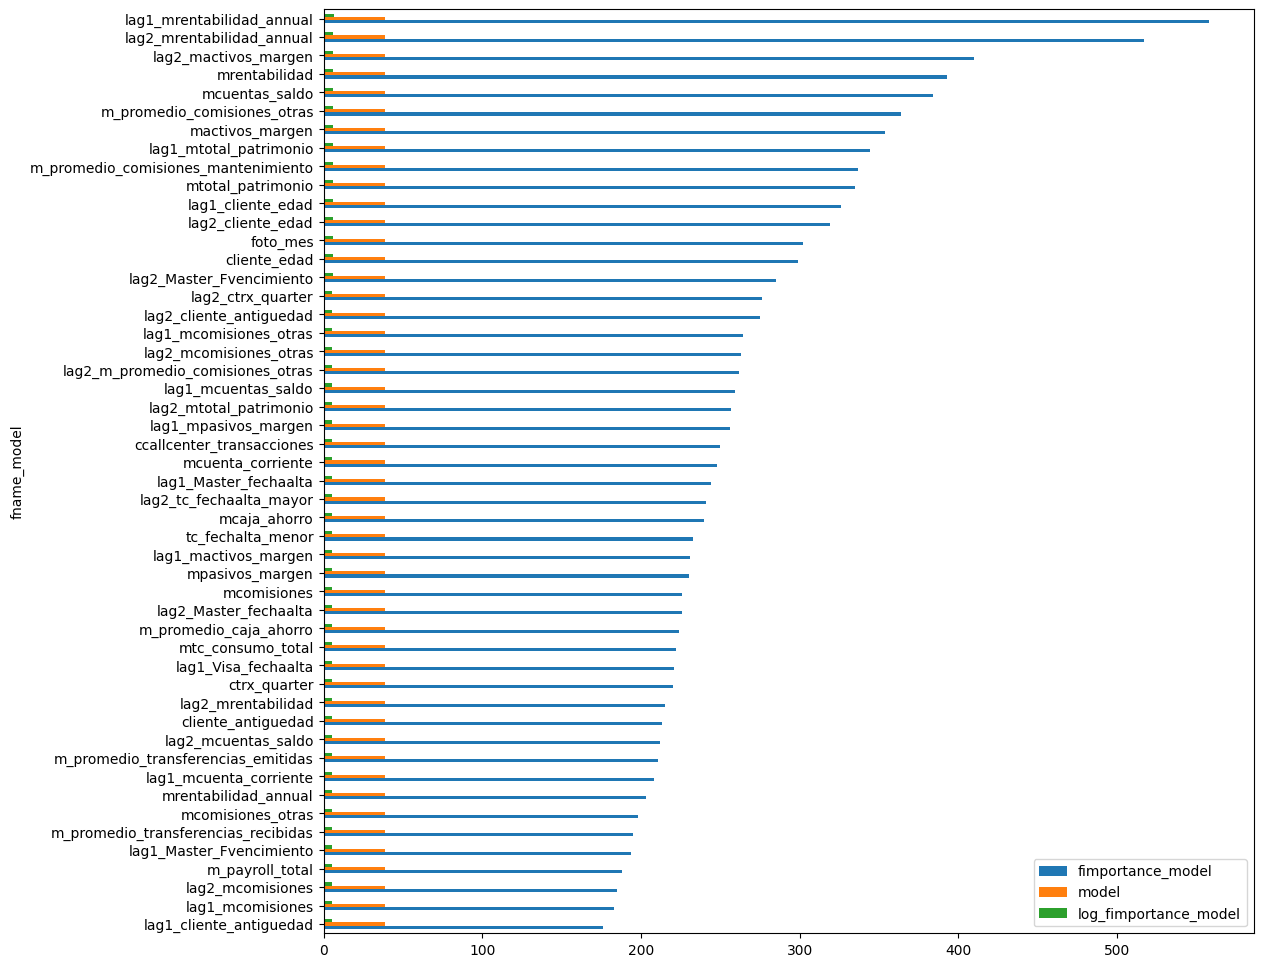

In [43]:

resumen_feature_importances.head(50).sort_values('fimportance_model').plot(kind='barh', figsize=(12, 12))

<Axes: ylabel='fname_model'>

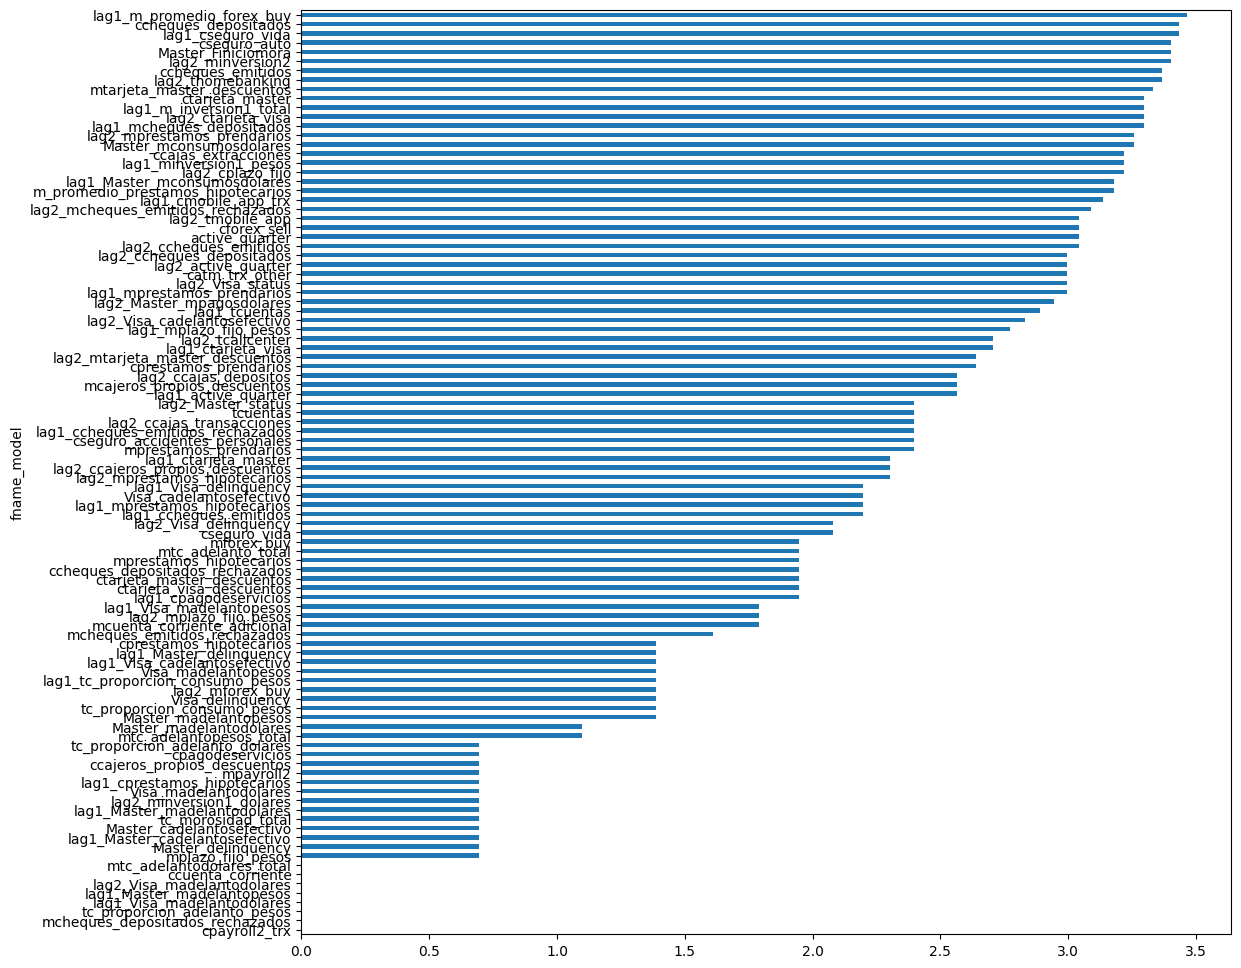

In [114]:
resumen_feature_importances.loc[:,'log_fimportance_model'].tail(100).sort_values(ascending=True).plot(kind='barh', figsize=(12, 12))

In [51]:
f_to_drop = resumen_feature_importances.loc[:,'log_fimportance_model'].tail(100).index.tolist()

In [57]:
pd.DataFrame({'fname': f_to_drop}, index=None).to_csv('features_to_drop.csv', index=False)